### I. Data Preparation

#### 1. Import and Standardize Data

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

In [2]:
# Suppress FutureWarning messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Set general display format for numbers
pd.options.display.float_format = '{:,.0f}'.format

# Define a function to format numbers
def format_number(x):
    return '{:,.2f}'.format(x)

In [4]:
# Define the formatting function for plots
from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return "{:,.0f}".format(value)

In [5]:
# Import historical contract data
folder = 'C:/Users/Eliza Bui/Dropbox/SaaS Contracts Analysis/'
file_name = 'PRO Contract Data EB2024.csv'
file_path = folder + file_name
raw_data = pd.read_csv(file_path)

In [6]:
# Take a look at overall structure
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RevPro ID           2070 non-null   object 
 1   Client ID           2070 non-null   object 
 2   Contract ID         2070 non-null   object 
 3   Product Code        2070 non-null   object 
 4   Start Date          2070 non-null   object 
 5   End Date            2070 non-null   object 
 6   Revenue             2070 non-null   int64  
 7   Recognized To Date  2070 non-null   int64  
 8   Contract Type       2070 non-null   object 
 9   Contracted Hours    2070 non-null   int64  
 10  Actual Hours        2070 non-null   float64
dtypes: float64(1), int64(3), object(7)
memory usage: 178.0+ KB


In [7]:
# Renaming the columns
raw_data.rename(columns={ 'Start Date': 'Rev Line Start Date',
                          'End Date': 'Rev Line End Date'
}, inplace=True)

# Standardize data type in each column
raw_data['Rev Line Start Date'] = pd.to_datetime(raw_data['Rev Line Start Date'])
raw_data['Rev Line End Date'] = pd.to_datetime(raw_data['Rev Line End Date'])
raw_data['Revenue'] = raw_data['Revenue'].astype(float)
raw_data['Recognized To Date'] = raw_data['Recognized To Date'].astype(float)
raw_data['Contracted Hours'] = raw_data['Contracted Hours'].astype(float)
#raw_data['Actual Hours'] = raw_data['Actual Hours'].astype(float)

# Take a peek into data
raw_data.head()

,RevPro ID,Client ID,Contract ID,Product Code,Rev Line Start Date,Rev Line End Date,Revenue,Recognized To Date,Contract Type,Contracted Hours,Actual Hours
0,RP-000001,Client 1,SUB121444,PRO1,2019-03-15,2020-03-14,"65,830","65,830",Fixed Term,600,162
1,RP-000002,Client 1,SUB121444,PRO1,2020-03-15,2021-03-14,"43,890","43,890",Fixed Term,400,210
2,RP-000003,Client 1,SUB121444,PRO1,2021-03-15,2022-03-14,"43,890","8,778",Fixed Term,400,80
3,RP-000004,Client 2,SUB121463,PRO1,2021-03-01,2022-02-28,"150,000","97,500",Fixed Term,"1,000",650
4,RP-000005,Client 3,SUB121534,PRO1,2019-07-01,2020-03-31,"60,000","60,000",Fixed Term,600,700


**Observation:** 
- The dataset has details at Revenue Line level, each has its own start date, end date, revenue/contract value associated with it. Unique ID for Revenue Lines is "RevPro ID"
- The first level of roll-up is "Contract ID", which can contain 1 or multiple "RevPro ID"
- The second level of roll-up is "Client ID", which can contain 1 or multiple "Contract ID"
<\br>

Thus, we can do analysis and calculation at 3 levels of details

#### 2. Add in Calculated Fields

In [8]:
# Define a function to map the month to the corresponding quarter based on Fiscal Year
def get_fiscal_quarter(month):
    if month.month < 4:
        return 'Q3'
    elif month.month < 7:
        return 'Q4'
    elif month.month < 10:
        return 'Q1'
    else:
        return 'Q2'

# Define a function to map the month to the corresponding Fiscal Year
def get_fiscal_year(month):
    if month.month < 7:
        return month.year
    else:
        return month.year+1

In [9]:
# Calculate the difference in months and years with fractional
def month_diff(d1, d2):
    d3 = d2 + DateOffset(days=1)
    years_diff = d3.year - d1.year
    months_diff = d3.month - d1.month
    days_diff = d3.day - d1.day
    
    # calculate total months
    total_months = years_diff * 12 + months_diff
    # adjust for the cases for fractional month
    if days_diff < 0:
        total_months -= 1
    fractional_months = days_diff / 30
    return total_months + fractional_months

def year_diff(d1, d2):
    d3 = d2 + DateOffset(days=1)
    years_diff = d3.year - d1.year
    months_diff = d3.month - d1.month
    days_diff = d3.day - d1.day
    
    total_years = years_diff + months_diff / 12 + days_diff / 365
    return total_years

In [10]:
# Declare date of analysis
date_of_consideration = pd.to_datetime('2022-01-31')

In [11]:
# Calculate revenue line length in days between start and end, inclusive
raw_data['Rev Line Length (days)'] = (raw_data['Rev Line End Date'] - raw_data['Rev Line Start Date']).dt.days + 1

# Calculate Revenue Line length in months with fraction
raw_data['Rev Line Length (months)'] = raw_data.apply(
                                    lambda x: month_diff(x['Rev Line Start Date'], x['Rev Line End Date']), axis=1)

# Calculate Revenue Line length in months with fraction
raw_data['Rev Line Length (years)'] = raw_data.apply(
                                    lambda x: year_diff(x['Rev Line Start Date'], x['Rev Line End Date']), axis=1)

# Group by 'Client ID' and 'Contract ID' and calculate start dates and fiscal period for each contract
raw_data['Contract Start Date'] = pd.to_datetime(
                        raw_data.groupby(['Client ID', 'Contract ID'])['Rev Line Start Date'].transform('min'))

# Group by 'Client ID' and 'Contract ID' and calculate end dates and fiscal period for each contract
raw_data['Contract End Date'] = pd.to_datetime(
                        raw_data.groupby(['Client ID', 'Contract ID'])['Rev Line End Date'].transform('max'))

# Calculate contract length in days between start and end, inclusive
raw_data['Contract Length (days)'] = (raw_data['Contract End Date'] - raw_data['Contract Start Date']).dt.days+1

# Calculate annualized contract value using fractional year for each revenue line
raw_data['RL ACV'] = raw_data.apply(lambda row: row['Revenue'] if row['Rev Line Length (days)'] < 366 
                                                else row['Revenue']/row['Rev Line Length (years)'], axis=1)

# Calculate daily contract value using fractional year for each revenue line
raw_data['RL DCV'] = raw_data['Revenue'] / raw_data['Contract Length (days)']

# Add a new column 'Active' indicating if the revenue line is still active or ended
#raw_data['RL Active'] = raw_data['Rev Line End Date'] > date_of_consideration

# Define a function to determine Rev Line status
def get_RL_status(row):
    if row['Rev Line Start Date'] > date_of_consideration:
        return 'Future'
    elif row['Rev Line End Date'] < date_of_consideration:
        return 'Past'
    else:
        return 'Current'

# Apply the function to create the 'RL Status' column
raw_data['RL Status'] = raw_data.apply(get_RL_status, axis=1)

In [12]:
# Take a peek into data
#raw_data[raw_data['RL Status'] == 'Future'].head()
raw_data.head()

,RevPro ID,Client ID,Contract ID,Product Code,Rev Line Start Date,Rev Line End Date,Revenue,Recognized To Date,Contract Type,Contracted Hours,Actual Hours,Rev Line Length (days),Rev Line Length (months),Rev Line Length (years),Contract Start Date,Contract End Date,Contract Length (days),RL ACV,RL DCV,RL Status
0,RP-000001,Client 1,SUB121444,PRO1,2019-03-15,2020-03-14,"65,830","65,830",Fixed Term,600,162,366,12,1,2019-03-15,2022-03-14,1096,"65,830",60,Past
1,RP-000002,Client 1,SUB121444,PRO1,2020-03-15,2021-03-14,"43,890","43,890",Fixed Term,400,210,365,12,1,2019-03-15,2022-03-14,1096,"43,890",40,Past
2,RP-000003,Client 1,SUB121444,PRO1,2021-03-15,2022-03-14,"43,890","8,778",Fixed Term,400,80,365,12,1,2019-03-15,2022-03-14,1096,"43,890",40,Current
3,RP-000004,Client 2,SUB121463,PRO1,2021-03-01,2022-02-28,"150,000","97,500",Fixed Term,"1,000",650,365,12,1,2021-03-01,2022-02-28,365,"150,000",411,Current
4,RP-000005,Client 3,SUB121534,PRO1,2019-07-01,2020-03-31,"60,000","60,000",Fixed Term,600,700,275,9,1,2019-07-01,2024-03-31,1736,"60,000",35,Past


In [13]:
#raw_data.info()

#### 3. Create a new dataframe for ARR waterfall

In [14]:
# Get earliest start date in dataset
earliest_start_date = pd.to_datetime(raw_data['Rev Line Start Date'].min())
print("Earliest start date:", earliest_start_date)

Earliest start date: 2016-10-01 00:00:00


In [15]:
# Generate quarterly dates between earliest_start_date and date_of_consideration
quarterly_dates = pd.date_range(start=earliest_start_date, end=date_of_consideration, freq='Q')

# Copy data to new dataframe to add ARR as of specific dates in
ARR_df = raw_data.copy()

In [16]:
# Function to calculate ARR at specific date
def calculate_ARR(specific_date, df):
    arr_values = []
    for _, row in df.iterrows():
        if row['Rev Line Start Date'] <= specific_date <= row['Rev Line End Date']:
            arr_values.append(row['RL ACV'])
        else:
            arr_values.append(0)
    return arr_values

# Create a DataFrame specific_date_tracker with datetime values without hours
specific_date_tracker = pd.DataFrame({'specific_date': quarterly_dates.date,
                                     'ARR_df_col_name': [f'ARR_as_of_{date.date()}' for date in quarterly_dates]})

In [17]:
#specific_date_tracker

In [18]:
# Iterate over each quarter-end date in the list and calculate ARR as of each specific date
ARR_results = {}
for specific_date in quarterly_dates:
    arr_values = calculate_ARR(specific_date, ARR_df)
    ARR_results[specific_date.date()] = arr_values

# Add ARR as of each specific date as individual column to ARR_df
for specific_date, arr_values in ARR_results.items():
    ARR_df[f'ARR_as_of_{specific_date}'] = arr_values

In [19]:
ARR_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   RevPro ID                 2070 non-null   object        
 1   Client ID                 2070 non-null   object        
 2   Contract ID               2070 non-null   object        
 3   Product Code              2070 non-null   object        
 4   Rev Line Start Date       2070 non-null   datetime64[ns]
 5   Rev Line End Date         2070 non-null   datetime64[ns]
 6   Revenue                   2070 non-null   float64       
 7   Recognized To Date        2070 non-null   float64       
 8   Contract Type             2070 non-null   object        
 9   Contracted Hours          2070 non-null   float64       
 10  Actual Hours              2070 non-null   float64       
 11  Rev Line Length (days)    2070 non-null   int64         
 12  Rev Line Length (mon

In [20]:
ARR_df.head(5)

,RevPro ID,Client ID,Contract ID,Product Code,Rev Line Start Date,Rev Line End Date,Revenue,Recognized To Date,Contract Type,Contracted Hours,...,ARR_as_of_2019-09-30,ARR_as_of_2019-12-31,ARR_as_of_2020-03-31,ARR_as_of_2020-06-30,ARR_as_of_2020-09-30,ARR_as_of_2020-12-31,ARR_as_of_2021-03-31,ARR_as_of_2021-06-30,ARR_as_of_2021-09-30,ARR_as_of_2021-12-31
0,RP-000001,Client 1,SUB121444,PRO1,2019-03-15,2020-03-14,"65,830","65,830",Fixed Term,600,...,"65,830","65,830",0,0,0,0,0,0,0,0
1,RP-000002,Client 1,SUB121444,PRO1,2020-03-15,2021-03-14,"43,890","43,890",Fixed Term,400,...,0,0,"43,890","43,890","43,890","43,890",0,0,0,0
2,RP-000003,Client 1,SUB121444,PRO1,2021-03-15,2022-03-14,"43,890","8,778",Fixed Term,400,...,0,0,0,0,0,0,"43,890","43,890","43,890","43,890"
3,RP-000004,Client 2,SUB121463,PRO1,2021-03-01,2022-02-28,"150,000","97,500",Fixed Term,"1,000",...,0,0,0,0,0,0,"150,000","150,000","150,000","150,000"
4,RP-000005,Client 3,SUB121534,PRO1,2019-07-01,2020-03-31,"60,000","60,000",Fixed Term,600,...,"60,000","60,000","60,000",0,0,0,0,0,0,0


### II. Revenue Line (RevPro ID) Level Analysis

In [21]:
raw_data[['Rev Line Length (months)', 'Revenue', 'Recognized To Date', 'Contracted Hours', 'Actual Hours', 'RL ACV']].describe()

,Rev Line Length (months),Revenue,Recognized To Date,Contracted Hours,Actual Hours,RL ACV
count,"2,070","2,070","2,070","2,070","2,070","2,070"
mean,11,"79,512","35,539",573,175,"78,416"
std,2,"62,823","58,591",395,313,"61,016"
min,1,0,0,10,0,0
25%,12,"40,542",0,360,0,"39,952"
50%,12,"65,745","11,296",500,19,"64,090"
75%,12,"101,172","54,772",650,233,"99,994"
max,17,"1,097,650","1,097,650","7,440","3,200","878,120"


#### 1. Revenue Line Length Review

In [22]:
raw_data_fixed_term = raw_data[raw_data['Contract Type'] == 'Fixed Term']
raw_data_opt_out = raw_data[raw_data['Contract Type'] == 'Opt Out']

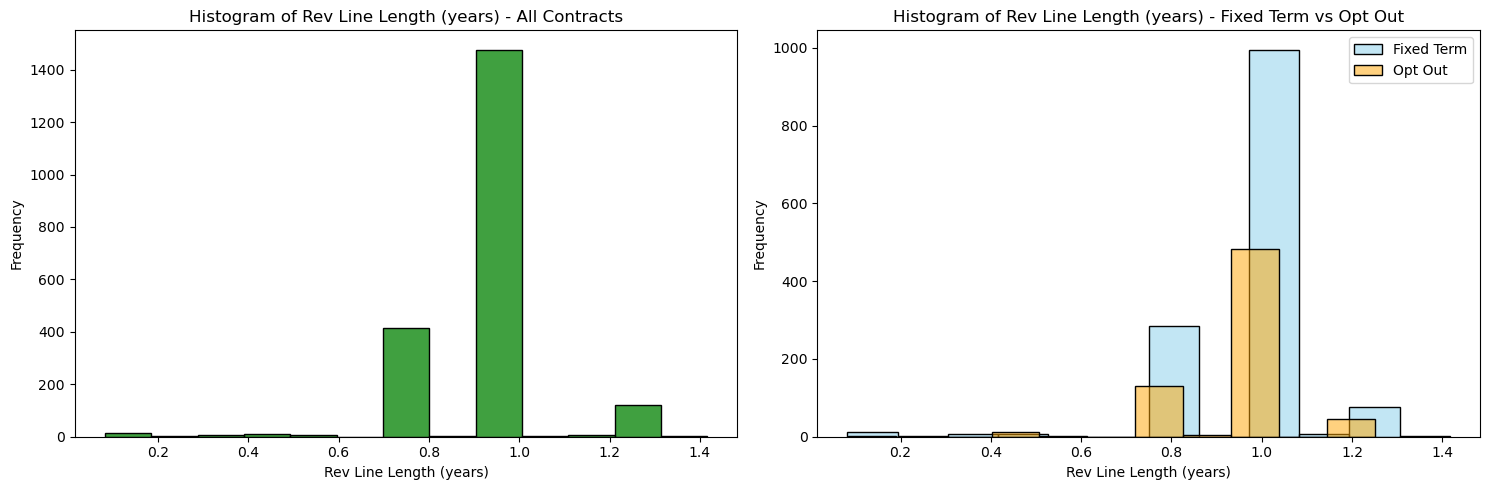

In [23]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for all contract types
sns.histplot(data=raw_data, x='Rev Line Length (years)', color='green', ax=axes[0])
axes[0].set_title('Histogram of Rev Line Length (years) - All Contracts')
axes[0].set_xlabel('Rev Line Length (years)')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'Fixed Term' and 'Opt Out' contracts overlapping
sns.histplot(data = raw_data_fixed_term, x='Rev Line Length (years)', color='skyblue', alpha=0.5, label='Fixed Term', ax=axes[1])
sns.histplot(data = raw_data_opt_out, x='Rev Line Length (years)', color='orange', alpha=0.5, label='Opt Out', ax=axes[1])
axes[1].set_title('Histogram of Rev Line Length (years) - Fixed Term vs Opt Out')
axes[1].set_xlabel('Rev Line Length (years)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Observations:**
- The overwhelming majority of RevPro ID lines are 1-year length with only a handlful of outliers of 1 months, 9 months, 16 months
- Both Fixed Term and Opt Out contracts contain one or multimple RevPro ID lines that are normally 1-year long
- The standard practice here is that for multi-year deals, revenue is broken down into multiple annual cycle, each with its own obligation (in terms of contracted hours) and associated revenue
- This Accounting practice is pretty common, especially in the world of ASC606 where all revenue accrual is driven by performance obligation

#### 2. Revenue Line ACV Review

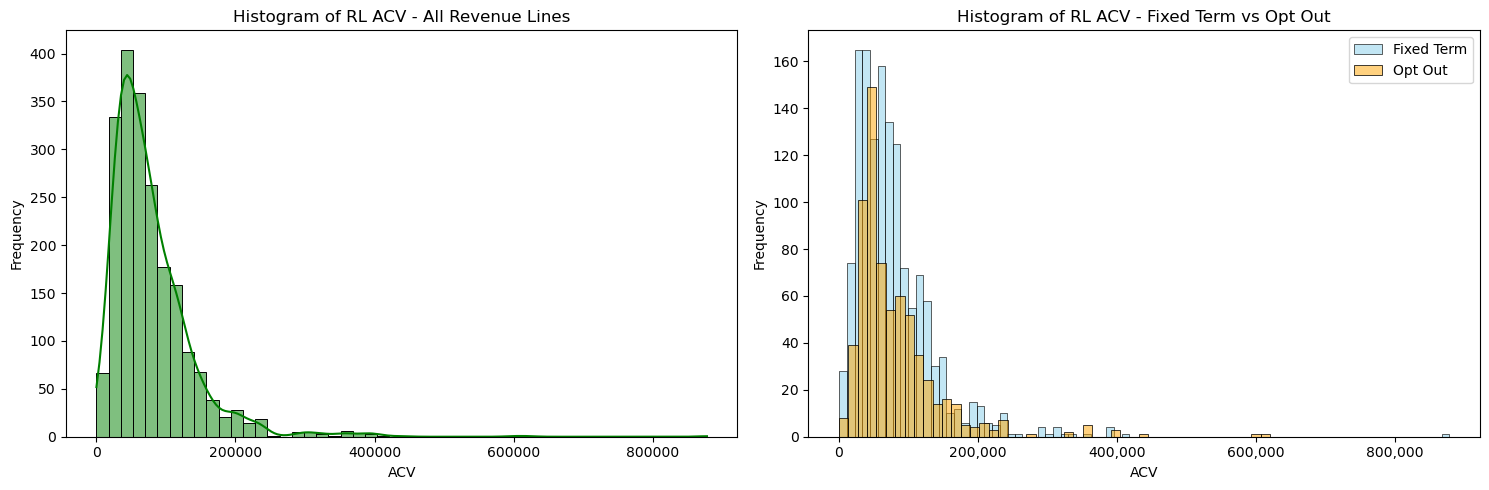

In [24]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for 'Revenue' for all contract types
sns.histplot(data = raw_data, x='RL ACV', color='green', kde=True, bins=50, ax=axes[0])
axes[0].set_title('Histogram of RL ACV - All Revenue Lines')
axes[0].set_xlabel('ACV')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'Revenue' for 'Fixed Term' and 'Opt Out' contracts overlapping
sns.histplot(data = raw_data_fixed_term, x='RL ACV', color='skyblue', alpha=0.5, label='Fixed Term', ax=axes[1])
sns.histplot(data = raw_data_opt_out, x='RL ACV', color='orange', alpha=0.5, label='Opt Out', ax=axes[1])
axes[1].set_title('Histogram of RL ACV - Fixed Term vs Opt Out')
axes[1].set_xlabel('ACV')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Apply the formatting function to the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))

# Show the plot
plt.show()

**Observations:**
- Since the majority of RevPro line is for 1-yr length, Revenue ~ ACV at revenue line level
- There isn't much differences between Fixed term and Opt Out contracts
- Revenue Lines of more than 400k are outliers that are worth further review

### III. Contract Level Analysis - Full population

In [25]:
# Summarize revenue data at contract level which is one level higher than revenue line level
contract_df = raw_data.groupby('Contract ID').agg({
    'Client ID': 'first',            # Keep the first value of Client ID
    'Contract Type': 'first',        # Keep the first value of Contract Type
    'Product Code': 'nunique',       # Count the number of unique Product Code
    'Contract Start Date': 'min',    # Keep the first value of Contract Start Date
    'Contract End Date': 'max',      # Keep the first value of Contract End Date
    'Revenue': 'sum',                # Sum of Revenue
    'Recognized To Date': 'sum',     # Sum of Recognized To Date
    'Contracted Hours': 'sum',       # Sum of Contracted Hours
    'Actual Hours': 'sum'            # Sum of Actual Hours
}).reset_index()  # Reset index to make 'Contract ID' a column

# Renaming the columns
contract_df.rename(columns={ 'Product Code': 'Number of Unique Product Code'}, inplace=True)

## Add calculated fields
# Calculate contract length in days between start and end, inclusive
contract_df['Contract Length (days)'] = (contract_df['Contract End Date'] - contract_df['Contract Start Date']).dt.days+1

# Get contract length in months with fractional
contract_df['Contract Length (months)'] = contract_df.apply(
                                    lambda x: month_diff(x['Contract Start Date'], x['Contract End Date']), axis=1)

# Get contract length in years with fractional
contract_df['Contract Length (years)'] = contract_df.apply(
                                    lambda x: year_diff(x['Contract Start Date'], x['Contract End Date']), axis=1)

# Calculate annualized contract value using fractional year for each revenue line
contract_df['ACV'] = contract_df.apply(lambda row: row['Revenue'] if row['Contract Length (years)'] < 1 
                                                else row['Revenue']/row['Contract Length (years)'], axis=1)

# Calculate daily contract value using fractional year for each revenue line
contract_df['DCV'] = contract_df['Revenue'] / contract_df['Contract Length (days)']

# Add a new column 'Active' indicating if the revenue line is still active or ended
contract_df['Contract Active'] = contract_df['Contract End Date'] > date_of_consideration

# Define a function to determine contract status
def get_contract_status(row):
    if row['Contract Start Date'] > date_of_consideration:
        return 'Future'
    elif row['Contract End Date'] <= date_of_consideration:
        return 'Past'
    else:
        return 'Current'

# Apply the function to create the 'Contract Status' column
contract_df['Contract Status'] = contract_df.apply(get_contract_status, axis=1)

In [26]:
# Take a look at a few top rows
contract_df.head()

,Contract ID,Client ID,Contract Type,Number of Unique Product Code,Contract Start Date,Contract End Date,Revenue,Recognized To Date,Contracted Hours,Actual Hours,Contract Length (days),Contract Length (months),Contract Length (years),ACV,DCV,Contract Active,Contract Status
0,SUB114967,Client 89,Fixed Term,1,2020-06-01,2023-05-31,"95,910","48,221",900,452,1095,36,3,"31,970",88,True,Current
1,SUB114968,Client 89,Fixed Term,1,2020-09-01,2023-05-31,"191,810","72,946","1,500",570,1003,33,3,"69,749",191,True,Current
2,SUB116028,Client 101,Fixed Term,1,2018-09-04,2023-09-03,"149,760","123,300","1,500","1,168",1826,60,5,"29,952",82,True,Current
3,SUB116030,Client 101,Fixed Term,1,2018-09-04,2023-09-03,"292,960","190,102","2,250","1,096",1826,60,5,"58,592",160,True,Current
4,SUB116039,Client 77,Fixed Term,1,2019-10-29,2021-07-28,"126,680","126,680",800,186,639,21,2,"72,389",198,False,Past


In [27]:
# Take a look at overall structure
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Contract ID                    670 non-null    object        
 1   Client ID                      670 non-null    object        
 2   Contract Type                  670 non-null    object        
 3   Number of Unique Product Code  670 non-null    int64         
 4   Contract Start Date            670 non-null    datetime64[ns]
 5   Contract End Date              670 non-null    datetime64[ns]
 6   Revenue                        670 non-null    float64       
 7   Recognized To Date             670 non-null    float64       
 8   Contracted Hours               670 non-null    float64       
 9   Actual Hours                   670 non-null    float64       
 10  Contract Length (days)         670 non-null    int64         
 11  Contract Length (mo

#### 1. How many products does each contract covers?

In [28]:
# See how many unique products each contract covers
display(contract_df['Number of Unique Product Code'].unique())
#contract_df[['Number of Unique Product Code']].describe()

array([1], dtype=int64)

**Observation:** Each contract is for ONE product code

#### 2. Get summary statistics by Contract Type

In [29]:
# Summarize revenue data at contract level which is one level higher than revenue line level
contract_type_df = contract_df.groupby('Contract Type').agg({
    'Contract ID': 'count',
    'Client ID': 'nunique',
    'Contract Active': 'sum',
    'Contract Length (years)': 'mean',
    'Revenue': 'mean',                
    'Recognized To Date': 'mean',     
    'ACV': 'mean',
    'Contracted Hours': 'mean',       
    'Actual Hours': 'mean'            
}).reset_index()

# Renaming the columns
contract_type_df.rename(columns={ 'Contract ID': 'Count of Unique Contract ID',
                                  'Client ID': 'Count of Unique Client ID',
                                  'Contract Active': 'Count of Active Contract',
                                  'Contract Length (years)': 'Average Contract Length (years)',
                                  'Revenue': 'Average TCV',
                                  'Recognized To Date': 'Average RTD',
                                  'ACV': 'Average ACV',
                                  'Contracted Hours': 'Average Contracted Hours',
                                  'Actual Hours': 'Average Actual Hours',                                 
                                }, inplace=True)

# Add progress columns
contract_type_df['Avg Rev RTD progress'] = contract_type_df['Average RTD']*100.0/contract_type_df['Average TCV']
contract_type_df['Avg Actual Hours progress'] = (contract_type_df['Average Actual Hours']*100.0/
                                                 contract_type_df['Average Contracted Hours'])

contract_type_df['Actual Hours as % Actual Rev RTD'] = (contract_type_df['Avg Actual Hours progress']*100.0/
                                                 contract_type_df['Avg Rev RTD progress'])

# Display dataframe
display(contract_type_df)

,Contract Type,Count of Unique Contract ID,Count of Unique Client ID,Count of Active Contract,Average Contract Length (years),Average TCV,Average RTD,Average ACV,Average Contracted Hours,Average Actual Hours,Avg Rev RTD progress,Avg Actual Hours progress,Actual Hours as % Actual Rev RTD
0,Fixed Term,467,189,369,3,"233,618","106,953","79,631","1,617",523,46,32,71
1,Opt Out,203,89,155,3,"273,352","116,350","94,301","2,125",580,43,27,64


**Observations:**
- Numbers of clients and contracts having Fixed Term type is more than 2x those with Opt Out type
- Average Contract Length is roughly the same between 2 different kinds of Contract Type, around 2.8 yr 
<br>

- Average TCV for Opt Out is **17% HIGHER** than Average TCV for Fixed Term
- Average Contracted Hours for Opt Out is **31% HIGHER** than Average Contracted Hours for Fixed Term
- Revenue Recognized To Date progress at 46% for Fixed Term is higher than Opt Out at 42.5% <br>
<br>

- Actual Hours progress, measured as Actual Hours / Contracted Hours, is only 2/3 of Actual Revenue Recognized To Date, due to the impact of "use it or loose it" rule, which true up all revenue accrual at end date of each revenue line even when clients didn't use all contracted hours 

In [30]:
# Create new DataFrame for 'Fixed Term' contracts
fixed_term_df = contract_df[contract_df['Contract Type'] == 'Fixed Term']

# Create new DataFrame for 'Opt Out' contracts
opt_out_df = contract_df[contract_df['Contract Type'] == 'Opt Out']

#### 3. Get summary statistics for Active contracts (Status = Current and Future) which will generate future revenue

In [31]:
# Summarize revenue data at contract level which is one level higher than revenue line level
contract_status_df = contract_df.groupby(['Contract Active','Contract Status']).agg({
    'Contract ID': 'count',
    'Client ID': 'nunique',
    'Contract Length (years)': 'mean',
    'Revenue': 'mean',                
    'Recognized To Date': 'mean',     
    'ACV': 'mean',
    'Contracted Hours': 'mean',       
    'Actual Hours': 'mean'            
}).reset_index()

# Renaming the columns
contract_status_df.rename(columns={ 
                                  'Contract ID': 'Count of Unique Contract ID',
                                  'Client ID': 'Count of Unique Client ID',
                                  'Contract Length (years)': 'Average Contract Length (years)',
                                  'Revenue': 'Average TCV',
                                  'Recognized To Date': 'Average RTD',
                                  'ACV': 'Average ACV',
                                  'Contracted Hours': 'Average Contracted Hours',
                                  'Actual Hours': 'Average Actual Hours',                                 
                                }, inplace=True)

# Add progress columns
contract_status_df['Avg Rev RTD progress'] = contract_status_df['Average RTD']*100.0/contract_status_df['Average TCV']
contract_status_df['Avg Actual Hours progress'] = (contract_status_df['Average Actual Hours']*100.0/
                                                 contract_status_df['Average Contracted Hours'])

contract_status_df['Actual Hours as % Actual Rev RTD'] = (contract_status_df['Avg Actual Hours progress']*100.0/
                                                 contract_status_df['Avg Rev RTD progress'])

# Display dataframe
display(contract_status_df)

,Contract Active,Contract Status,Count of Unique Contract ID,Count of Unique Client ID,Average Contract Length (years),Average TCV,Average RTD,Average ACV,Average Contracted Hours,Average Actual Hours,Avg Rev RTD progress,Avg Actual Hours progress,Actual Hours as % Actual Rev RTD
0,False,Past,146,81,2,"117,895","117,895","67,932",813,545,100,67,67
1,True,Current,507,241,3,"284,098","111,140","88,727","2,067",557,39,27,69
2,True,Future,17,11,2,"196,453",304,"84,014","1,159",2,0,0,90


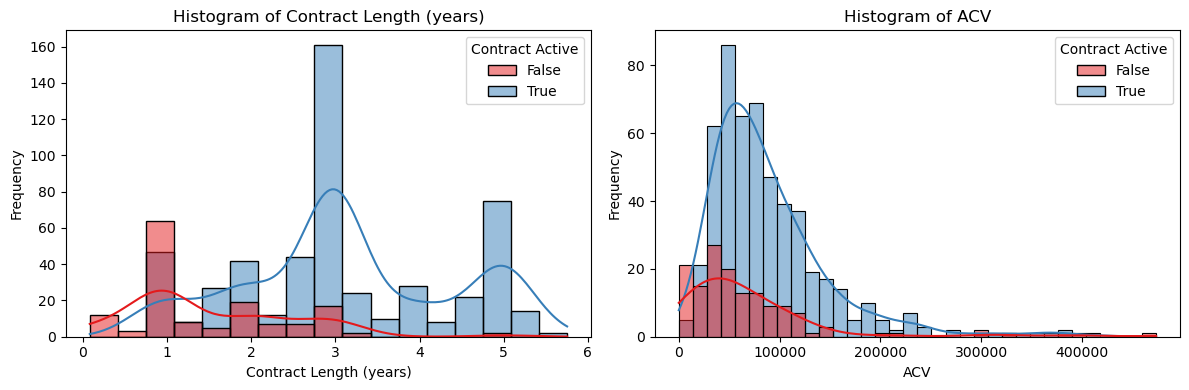

In [32]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram for "Contract Length (years)" with overlapping distributions based on "Contract Active"
sns.histplot(data=contract_df, x='Contract Length (years)', hue='Contract Active', kde=True, ax=axes[0], palette='Set1')
axes[0].set_title('Histogram of Contract Length (years)')
axes[0].set_xlabel('Contract Length (years)')
axes[0].set_ylabel('Frequency')

# Plot the histogram for "ACV" with overlapping distributions based on "Contract Active"
sns.histplot(data=contract_df, x='ACV', hue='Contract Active', kde=True, ax=axes[1], palette='Set1')
axes[1].set_title('Histogram of ACV')
axes[1].set_xlabel('ACV')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Observations:**
- "Active" contracts which haven't ended at the date of consideration have higher Average TCV, ACV, contract length, Contracted Hours than those ended. This indidates that overtime, this company is able to sign longer-term contracts of higher ACV values with clients. It signifies positive business growth.
<br>

- The majority of "Active" contracts are Currently active (currently generating revenue). Future contracts are early renewals, or in some rare cases, early sale (contracts already signed and entered in system but Start Date is in the future).
<br>

- Contracts that have ended have 100% of revenue recognized (Revenue = Recognized To Date) even though Actual Hours is only 67% of Contracted Hours. This confirmed the "use it or lose it" practice, which true up all revenue accrual at end date of each revenue line even when clients didn't use all contracted hours.

In [33]:
# Create new DataFrame for 'Active' contracts
active_contract_df = contract_df[contract_df['Contract Active'] == True]

# Create new DataFrame for 'Fixed Term' contracts
active_fixed_term_df = active_contract_df[active_contract_df['Contract Type'] == 'Fixed Term']

# Create new DataFrame for 'Opt Out' contracts
active_opt_out_df = active_contract_df[active_contract_df['Contract Type'] == 'Opt Out']

#### 4. Contract Length Review

In [34]:
# Take a look at main sstistic for contract length columns
contract_df[['Contract Length (years)', 'Contract Length (days)']].describe()

,Contract Length (years),Contract Length (days)
count,670,670
mean,3,"1,013"
std,1,500
min,0,30
25%,2,639
50%,3,"1,095"
75%,3,"1,187"
max,6,"2,101"


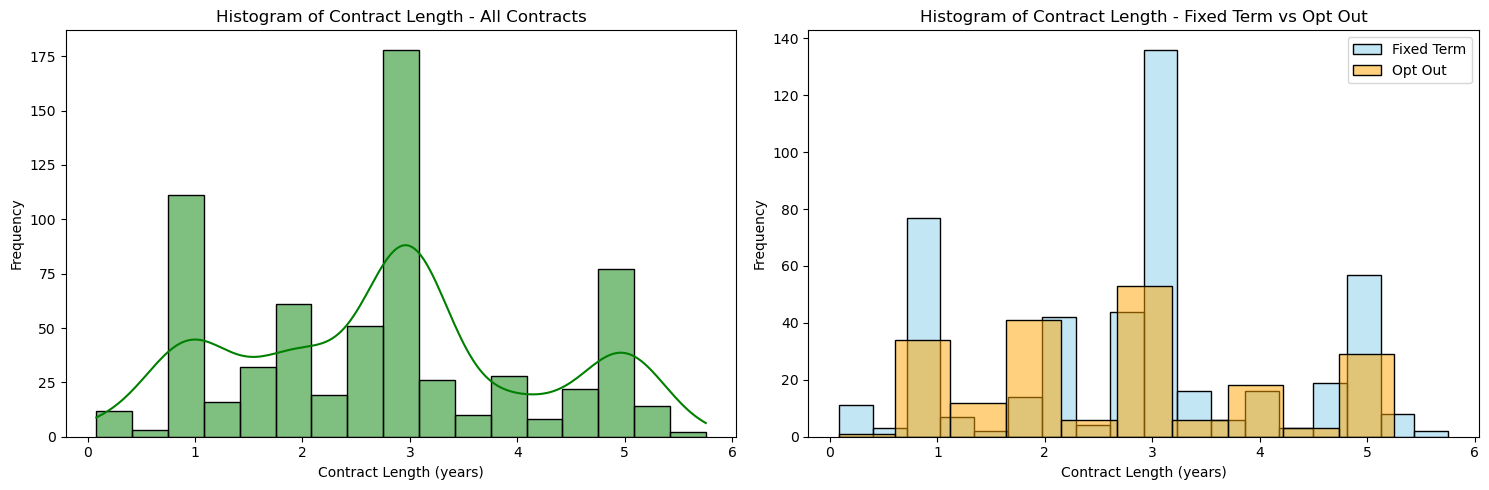

In [35]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for 'Contract Length (years)' for all contract types
sns.histplot(data=contract_df, x='Contract Length (years)', color='green', kde=True, ax=axes[0])
axes[0].set_title('Histogram of Contract Length - All Contracts')
axes[0].set_xlabel('Contract Length (years)')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'Contract Length (years)' for 'Fixed Term' and 'Opt Out' contracts overlapping
sns.histplot(data = fixed_term_df, x='Contract Length (years)', color='skyblue', alpha=0.5, label='Fixed Term', ax=axes[1])
sns.histplot(data = opt_out_df, x='Contract Length (years)', color='orange', alpha=0.5, label='Opt Out', ax=axes[1])
axes[1].set_title('Histogram of Contract Length - Fixed Term vs Opt Out')
axes[1].set_xlabel('Contract Length (years)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Observations:**
- Contract Length ranges from 1 month to 5.57 years
- The majority of contract length is a rounding number of years: 1, 2, 3, 4, 5 with 3 years being the median and mode
- Outliers on the lower ends (contracts of a few months length) should be looked into further to determine if they are recurring in nature, and hence should be counted in ARR calculation or not
- Although histogram of Contract Length (years) for Fixed Term and Opt Out contracts look very similar, there are higher peaks at 1 and 3 yr, meaning that there are significantly more Fixed Term contracts of 1yr and 3yr length vs Opt Out contracts

#### 5. Total Contract Value (TCV) Review

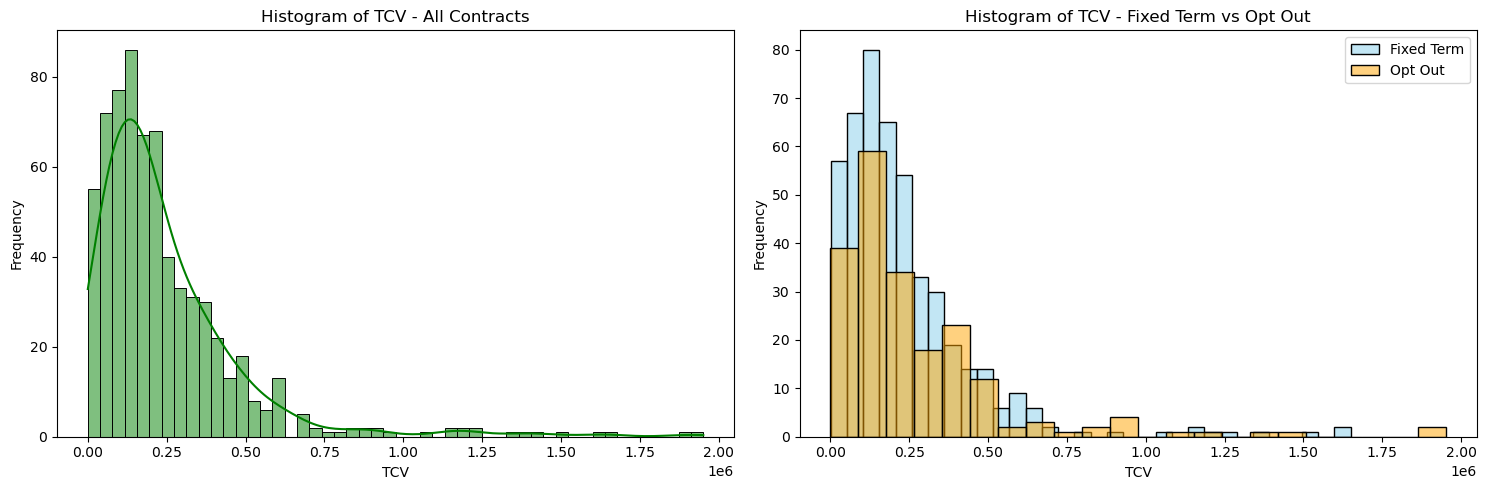

In [36]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for 'Revenue' for all contract types
sns.histplot(data=contract_df, x='Revenue', color='green', kde=True, bins=50, ax=axes[0])
axes[0].set_title('Histogram of TCV - All Contracts')
axes[0].set_xlabel('TCV')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'Revenue' for 'Fixed Term' and 'Opt Out' contracts overlapping
sns.histplot(data=fixed_term_df, x='Revenue', color='skyblue', alpha=0.5, label='Fixed Term', ax=axes[1])
sns.histplot(data=opt_out_df, x='Revenue', color='orange', alpha=0.5, label='Opt Out', ax=axes[1])
axes[1].set_title('Histogram of TCV - Fixed Term vs Opt Out')
axes[1].set_xlabel('TCV')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Get the statistical summary for ACV
TCV_summary = contract_df[['Revenue']].describe()
TCV_summary = TCV_summary.rename(columns={'Revenue': 'TCV'})

# Exclude contracts with TCV = $0
data1 = contract_df[contract_df['Revenue'] > 0]

# Get the statistical summary for ACV excluding $0 deals
TCV_excluding_0_summary = data1[['Revenue']].describe()
TCV_excluding_0_summary = TCV_excluding_0_summary.rename(columns={'Revenue': 'TCV excluding $0 deal'})

# Merge the two dataframes into one
TCV_stats_df = pd.concat([TCV_summary, TCV_excluding_0_summary], axis=1)

# Display the merged dataframe
display(TCV_stats_df)

,TCV,TCV excluding $0 deal
count,670,669
mean,"245,657","246,024"
std,"244,625","244,624"
min,0,980
25%,"102,485","102,740"
50%,"183,190","183,340"
75%,"318,245","318,600"
max,"1,951,530","1,951,530"


**Observations:**
- Distribution is right-skewed by outliers on the upper end as the longer the contract, the more revenue company should charge clients
- Mean TCV > Median TCV also confirmed the highly right-skewed distribution shape
- There is only 1 promo/free deal which we can exclude from analysis going forward

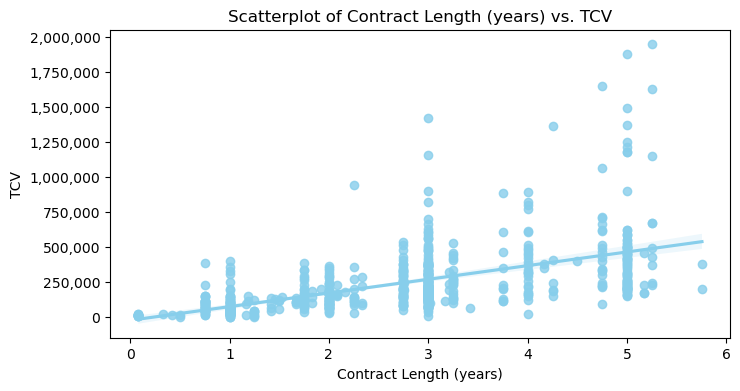

In [38]:
# Use scatterplot to see relationship of TCV and contract length better
plt.figure(figsize=(8, 4))
sns.regplot(data=contract_df, x='Contract Length (years)', y='Revenue', color='skyblue')
#sns.scatterplot(data = contract_df, x='Contract Length (years)', y='Revenue', color='purple')
plt.title('Scatterplot of Contract Length (years) vs. TCV')
plt.xlabel('Contract Length (years)')
plt.ylabel('TCV')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

**Observation:** This scatterplot confirms the logical guess that this company can and should charge more revenue for longer-term/multiyear deals

#### 6. Annualized Contract Value (ACV) Review

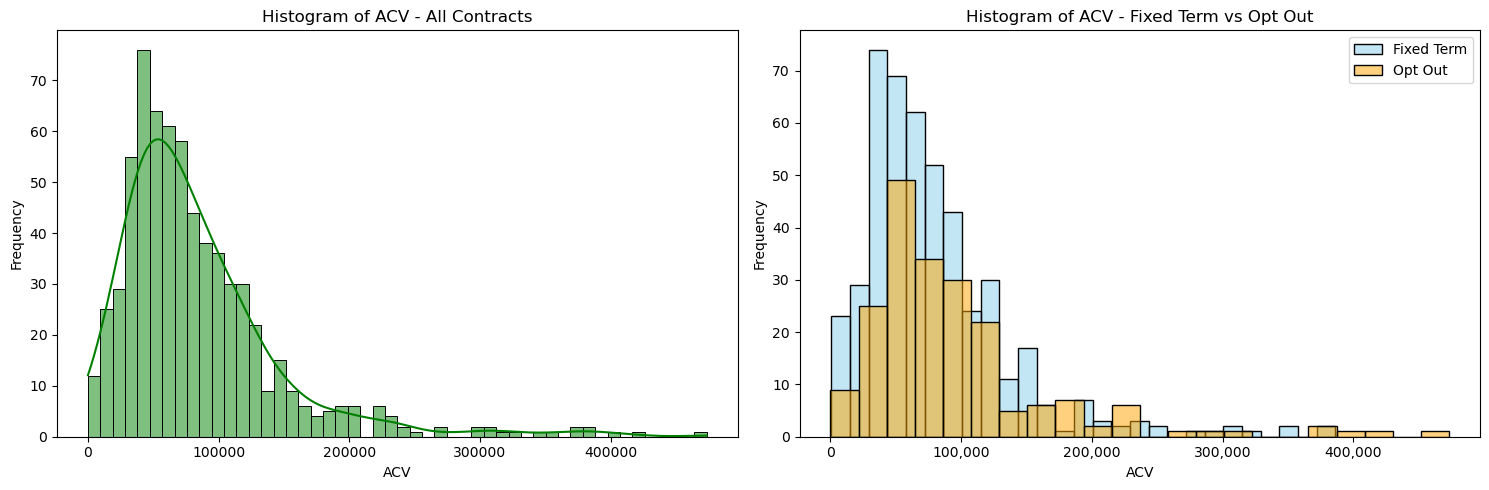

In [39]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for 'Revenue' for all contract types
sns.histplot(data=contract_df, x='ACV', color='green', kde=True, bins=50, ax=axes[0])
axes[0].set_title('Histogram of ACV - All Contracts')
axes[0].set_xlabel('ACV')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'Revenue' for 'Fixed Term' and 'Opt Out' contracts overlapping
sns.histplot(data=fixed_term_df, x='ACV', color='skyblue', alpha=0.5, label='Fixed Term', ax=axes[1])
sns.histplot(data=opt_out_df, x='ACV', color='orange', alpha=0.5, label='Opt Out', ax=axes[1])
axes[1].set_title('Histogram of ACV - Fixed Term vs Opt Out')
axes[1].set_xlabel('ACV')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Apply the formatting function to the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))

# Show the plot
plt.show()

In [40]:
# Get the statistical summary for ACV
ACV_summary = contract_df[['ACV']].describe()

# Exclude contracts with TCV = $0
data1 = contract_df[contract_df['Revenue'] > 0]

# Get the statistical summary for ACV excluding $0 deals
ACV_excluding_0_summary = data1[['ACV']].describe()
ACV_excluding_0_summary = ACV_excluding_0_summary.rename(columns={'ACV': 'ACV excluding $0 deal'})

# Merge the two dataframes into one
ACV_stats_df = pd.concat([ACV_summary, ACV_excluding_0_summary], axis=1)

# Display the merged dataframe
display(ACV_stats_df)

,ACV,ACV excluding $0 deal
count,670,669
mean,"84,076","84,202"
std,"63,841","63,806"
min,0,784
25%,"43,766","43,783"
50%,"69,590","69,699"
75%,"105,124","105,160"
max,"473,333","473,333"


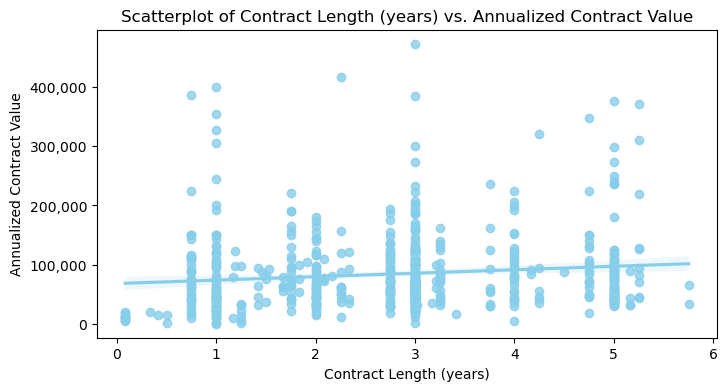

In [41]:
# Plot scatterplot 
plt.figure(figsize=(8, 4))
#sns.scatterplot(data = raw_data, x='Contract Length (years)', y='Annualized Contract Value', color='orange')
sns.regplot(data=contract_df, x='Contract Length (years)', y='ACV', color='skyblue')
plt.title('Scatterplot of Contract Length (years) vs. Annualized Contract Value')
plt.xlabel('Contract Length (years)')
plt.ylabel('Annualized Contract Value')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

#### Correlation between ACV and contract length

In [42]:
# Create a correlation matrix
correlation_matrix = contract_df[['Contract Length (years)', 'ACV']].corr()

# Extract correlation value
correlation_value = correlation_matrix.iloc[0, 1]

# Print correlation value
print("Correlation between 'Contract Length (years)' and 'ACV':", correlation_value)

Correlation between 'Contract Length (years)' and 'ACV': 0.12510265232964415


**Observation:** This scatter plot shows a a very weak correlation between contract length and ACV (which is different from contract length and TCV picture above).
- A few Contracts with ACV > 400k are 3-year and 1-year deals, which we should look into further to see if those contracts include special terms or add-on services
- A handul of outliers on both upper and lower ends should be looked into, but they are not the drivers of skewness in TCV or ACV
- Average ACV is 84k and Median ACV is 70k

#### 7. Daily Contract Value (DCV) Review

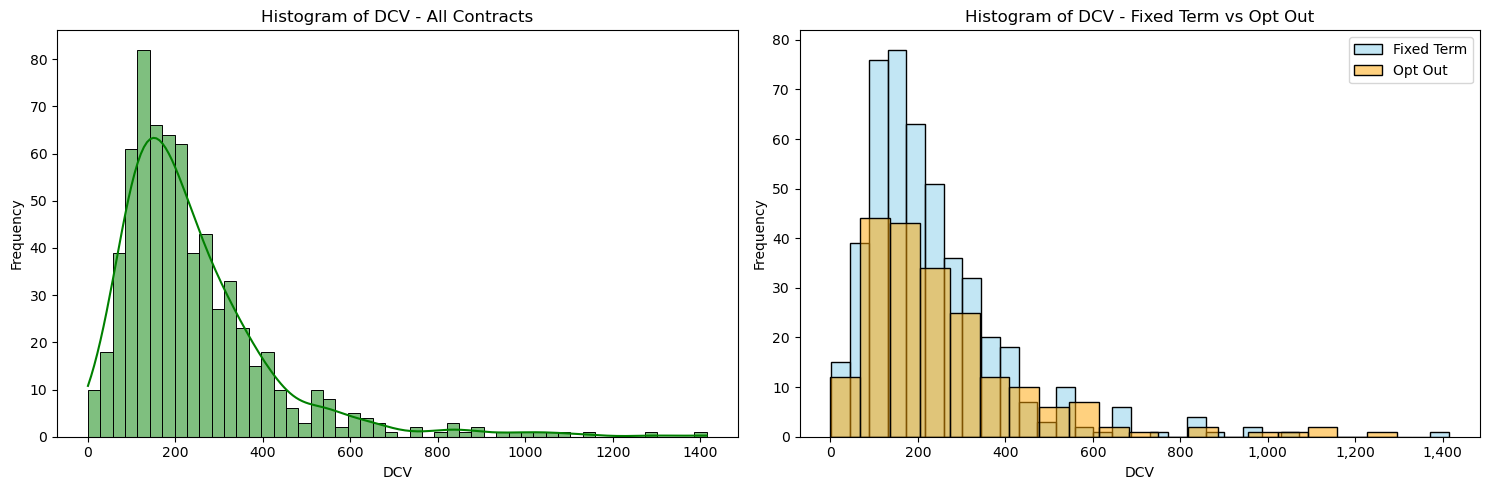

In [43]:
# Create subplots for the histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for 'Revenue' for all contract types
sns.histplot(data=contract_df, x='DCV', color='green', kde=True, bins=50, ax=axes[0])
axes[0].set_title('Histogram of DCV - All Contracts')
axes[0].set_xlabel('DCV')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'Revenue' for 'Fixed Term' and 'Opt Out' contracts overlapping
sns.histplot(data=fixed_term_df, x='DCV', color='skyblue', alpha=0.5, label='Fixed Term', ax=axes[1])
sns.histplot(data=opt_out_df, x='DCV', color='orange', alpha=0.5, label='Opt Out', ax=axes[1])
axes[1].set_title('Histogram of DCV - Fixed Term vs Opt Out')
axes[1].set_xlabel('DCV')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Apply the formatting function to the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))

# Show the plot
plt.show()

In [44]:
# Get the statistical summary for DCV
DCV_summary = contract_df[['DCV']].describe()

# Exclude contracts with TCV = $0
data1 = contract_df[contract_df['Revenue'] > 0]

# Get the statistical summary for DCV excluding $0 deals
DCV_excluding_0_summary = data1[['DCV']].describe()
DCV_excluding_0_summary = DCV_excluding_0_summary.rename(columns={'DCV': 'DCV excluding $0 deal'})

# Merge the two dataframes into one
DCV_stats_df = pd.concat([DCV_summary, DCV_excluding_0_summary], axis=1)

# Display the merged dataframe
display(DCV_stats_df)

,DCV,DCV excluding $0 deal
count,670,669
mean,241,241
std,180,180
min,0,2
25%,125,125
50%,197,197
75%,300,301
max,"1,415","1,415"


**Observation:** Same story we see with ACV

#### 8. All Contract Value Metrics Together

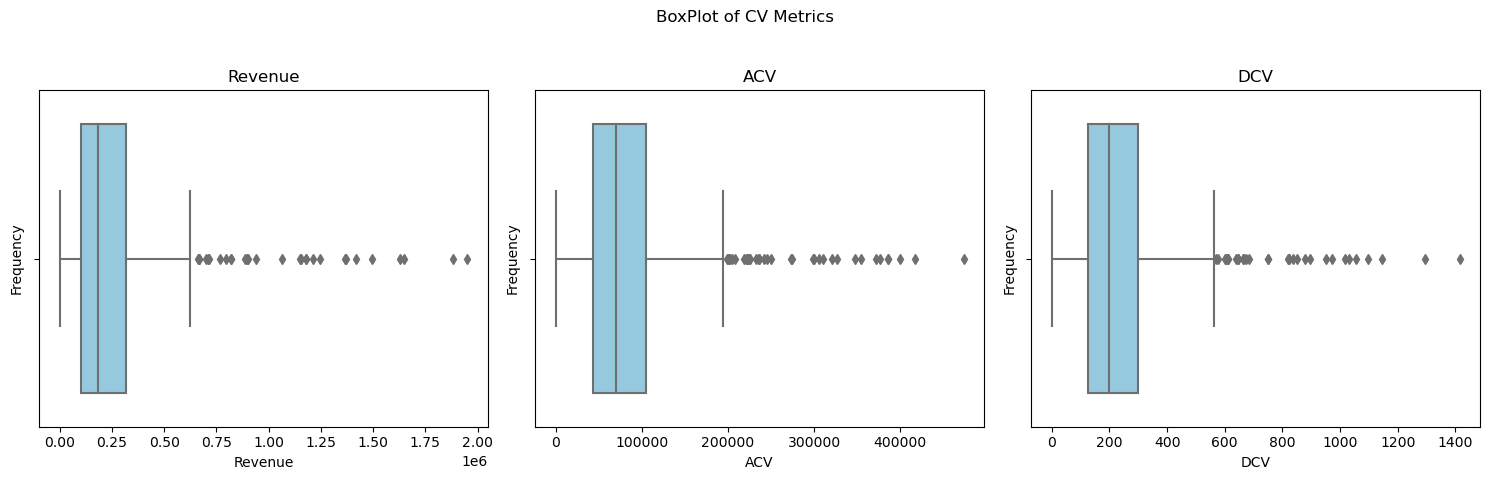

In [45]:
# Define the columns to create histograms
CV_metrics = ['Revenue', 'ACV', 'DCV']

# Create subplots for the histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('BoxPlot of CV Metrics')

for i, metric in enumerate(CV_metrics):
    sns.boxplot(data = contract_df, x=metric, color='skyblue', ax=axs[i]) # Updated indexing for axs
    axs[i].set_title(metric) 
    axs[i].set_xlabel(metric) 
    axs[i].set_ylabel('Frequency') 

# Adjust layout for better visual appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observation:** This dataset clearly has outliers in both Contract Length and ACV that need to be reviewed further. Including outliers that are not truly recurring annually could severly impact the accuracy of ARR calculation

#### 9. Let's ignore the top 10% of ACV values to zoom into the majority 90%

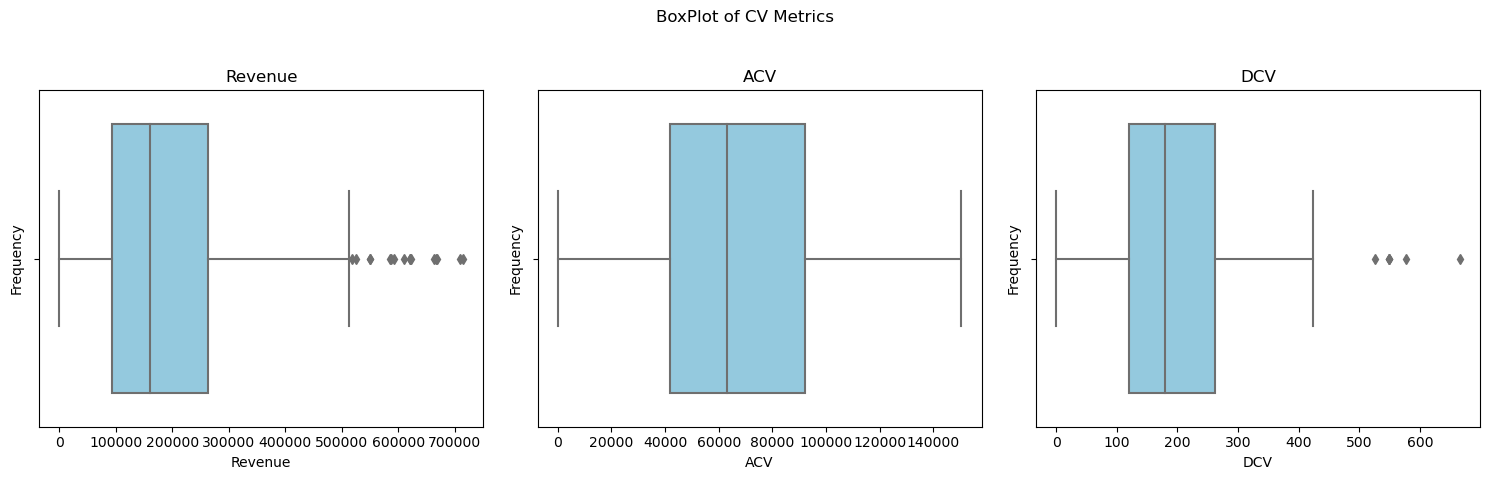

In [46]:
# Calculate the top quantiles
top_quantile = contract_df['ACV'].quantile(0.90)

# Exclude top values from this analysis
no_outlier_df = contract_df[(contract_df['ACV'] < top_quantile )]

# Define the columns for which you want to create histograms
CV_metrics = ['Revenue', 'ACV', 'DCV']

# Create subplots for the histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('BoxPlot of CV Metrics')

for i, metric in enumerate(CV_metrics):
    sns.boxplot(data = no_outlier_df, x=metric, color='skyblue', ax=axs[i]) # Updated indexing for axs
    axs[i].set_title(metric) 
    axs[i].set_xlabel(metric) 
    axs[i].set_ylabel('Frequency')
    # Format x-axis labels
    #axs[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Adjust layout for better visual appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

**Observation:** We should separate outlier contracts into their own bucket to investigate their specific details and figure out how the company can charge significantly more for those clients and contracts

### IV. Client Level Analysis

In [47]:
# Summarize revenue data at client level which is one level higher than contract level
client_sum_df = ARR_df.groupby(['Client ID']).agg({      
        'Contract ID': 'nunique',              
        'Contract Start Date': 'min',  
        'Contract End Date': 'max',    
        'Revenue': 'sum',                
        'Recognized To Date': 'sum',     
        'Contracted Hours': 'sum',       
        'Actual Hours': 'sum',
        'ARR_as_of_2016-12-31': 'sum',
        'ARR_as_of_2017-03-31': 'sum',
        'ARR_as_of_2017-06-30': 'sum',
        'ARR_as_of_2017-09-30': 'sum',
        'ARR_as_of_2017-12-31': 'sum',
        'ARR_as_of_2018-03-31': 'sum',
        'ARR_as_of_2018-06-30': 'sum',
        'ARR_as_of_2018-09-30': 'sum',
        'ARR_as_of_2018-12-31': 'sum',
        'ARR_as_of_2019-03-31': 'sum',
        'ARR_as_of_2019-06-30': 'sum',
        'ARR_as_of_2019-09-30': 'sum',
        'ARR_as_of_2019-12-31': 'sum',
        'ARR_as_of_2020-03-31': 'sum',
        'ARR_as_of_2020-06-30': 'sum',
        'ARR_as_of_2020-09-30': 'sum',
        'ARR_as_of_2020-12-31': 'sum',
        'ARR_as_of_2021-03-31': 'sum',
        'ARR_as_of_2021-06-30': 'sum',
        'ARR_as_of_2021-09-30': 'sum',
        'ARR_as_of_2021-12-31': 'sum'
}).reset_index()

# Renaming the columns
client_sum_df.rename(columns={ 'Contract ID': 'Count of Contract ID',
                                'Contract Start Date': 'Client Earliest Start Date',
                                'Contract End Date':   'Client Last End Date',
                                'Revenue': 'Total TCV',
                                'Recognized To Date': 'Total RTD',     
                                'Contracted Hours': 'Total Contracted Hours',       
                                'Actual Hours': 'Total Actual Hours'
                         }, inplace=True)

## Add calculated fields
# Calculate the 'Client Cohort Start Month' as the first day of the month of 'Client Earliest Start Date'
client_sum_df['Client Cohort Start Month'] = client_sum_df['Client Earliest Start Date'].dt.to_period('M').dt.to_timestamp()

# Apply the function to calculate the 'Client Cohort Start Quarter'
client_sum_df['Client Cohort Start FQ'] = client_sum_df['Client Cohort Start Month'].apply(get_fiscal_quarter)

# Apply the function to calculate the 'Client Cohort Start Year'
client_sum_df['Client Cohort Start FY'] = client_sum_df['Client Cohort Start Month'].apply(get_fiscal_year)

# Calculate engagement length in months with fractional between start and end, inclusive
client_sum_df['Engagement Length (months)'] = client_sum_df.apply(
                                    lambda x: month_diff(x['Client Earliest Start Date'], x['Client Last End Date']), axis=1)

# Get contract length in years with fractional
client_sum_df['Engagement Length (years)'] = client_sum_df.apply(
                                    lambda x: year_diff(x['Client Earliest Start Date'], x['Client Last End Date']), axis=1)

# Calculate Revenue per Hours
client_sum_df['Rev per Hour'] = client_sum_df['Total TCV'] / client_sum_df['Total Contracted Hours']

# Add a new column 'Active' indicating if client is still active or ended
client_sum_df['Client Active'] = client_sum_df['Client Last End Date'] > date_of_consideration

# Define a function to determine contract status
def get_client_status(row):
    if row['Client Earliest Start Date'] > date_of_consideration:
        return 'Future'
    elif row['Client Last End Date'] <= date_of_consideration:
        return 'Past'
    else:
        return 'Current'

# Apply the function to create the 'Contract Status' column
client_sum_df['Client Status'] = client_sum_df.apply(get_client_status, axis=1)

In [48]:
# Preview client dataframe
#client_sum_df.info()

In [49]:
# Preview client dataframe
client_sum_df.head()

,Client ID,Count of Contract ID,Client Earliest Start Date,Client Last End Date,Total TCV,Total RTD,Total Contracted Hours,Total Actual Hours,ARR_as_of_2016-12-31,ARR_as_of_2017-03-31,...,ARR_as_of_2021-09-30,ARR_as_of_2021-12-31,Client Cohort Start Month,Client Cohort Start FQ,Client Cohort Start FY,Engagement Length (months),Engagement Length (years),Rev per Hour,Client Active,Client Status
0,Client 1,3,2019-03-15,2022-03-14,"684,680","568,919","5,700","3,757",0,0,...,"168,980","168,980",2019-03-01,Q3,2019,36,3,120,True,Current
1,Client 10,3,2018-03-31,2023-05-31,"852,730","601,745","7,180","4,276",0,0,...,"145,760","145,760",2018-03-01,Q3,2018,61,5,119,True,Current
2,Client 100,2,2021-01-15,2023-06-30,"167,741","38,750","1,160",279,0,0,...,"38,750","38,750",2021-01-01,Q3,2021,29,2,145,True,Current
3,Client 101,11,2018-09-04,2023-09-29,"2,550,240","1,811,786","21,140","10,238",0,0,...,"309,566","469,586",2018-09-01,Q1,2019,61,5,121,True,Current
4,Client 102,2,2020-07-01,2023-06-30,"264,460","122,169","1,800",818,0,0,...,"25,430","88,150",2020-07-01,Q1,2021,36,3,147,True,Current


#### 1. Get a statistical summary of Past and Active Clients

In [50]:
# Summarize revenue data at client level which is one level higher than contract level
client_status_df = client_sum_df.groupby(['Client Status']).agg({      
    'Client ID': 'nunique',             
    'Engagement Length (years)': 'mean',
    #'Rev per Hour': 'mean',
    'Total TCV': 'sum',                   
    'Total Contracted Hours': 'sum'          
}).reset_index()

# Renaming the columns
client_status_df.rename(columns={ 'Client ID': 'Count of Client',
                                'Engagement Length (years)': 'Avg Engagement Length (years)',
                                #'Rev per Hour': 'Avg Rev per Hour',
                                'Total TCV': 'Total TCV',                    
                                'Total Contracted Hours': 'Total Contracted Hours'
                         }, inplace=True)

# Add columns for total TCV and total contracted hours
client_status_df['Avg TCV'] = client_sum_df.groupby('Client Status')['Total TCV'].mean().values
client_status_df['Avg Contracted Hours'] = client_sum_df.groupby('Client Status')['Total Contracted Hours'].mean().values
client_status_df['Avg Rev per Engagement Year'] = client_status_df['Avg TCV'] / client_status_df['Avg Engagement Length (years)']
client_status_df['Avg Rev per Hour'] = client_status_df['Total TCV'] / client_status_df['Total Contracted Hours']

# Set display format for numbers
pd.options.display.float_format = '{:,.0f}'.format
# Set format for Avg Engagement Length (years)
client_status_df['Avg Engagement Length (years)'] = client_status_df['Avg Engagement Length (years)'].map('{:,.2f}'.format)

display(client_status_df)

,Client Status,Count of Client,Avg Engagement Length (years),Total TCV,Total Contracted Hours,Avg TCV,Avg Contracted Hours,Avg Rev per Engagement Year,Avg Rev per Hour
0,Current,245,3.40,"159,800,599","1,151,140","652,247","4,699","191,795",139
1,Past,19,2.05,"4,789,414","35,250","252,074","1,855","122,942",136


**Observations:**
- The vast majority of clients continue to do business with this firm
- For clients that continue to buy services, the firm is able to sell longer-term contracts at higher annualized revenue values
- Yet, given that average revenue per hour only increases slightly, the higher revenue is mostly driven by selling more contracted hours, not by increaseing hourly rate, which is something we should look into

#### 2. Distribution of Contracted Hours and Hourly Revenue by Active Clients

In [51]:
# Get a separate data frame for active clients
active_client_df = client_sum_df[client_sum_df['Client Active'] == True]

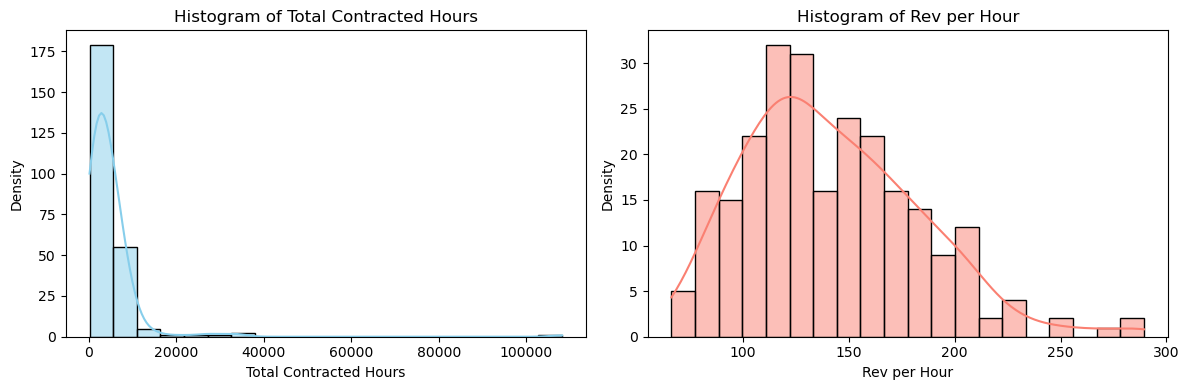

In [52]:
# Create a figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram with KDE for 'Total Contracted Hours'
sns.histplot(data=active_client_df, x='Total Contracted Hours', bins=20, color='skyblue', kde=True, ax=axs[0])
axs[0].set_title('Histogram of Total Contracted Hours')
axs[0].set_xlabel('Total Contracted Hours')
axs[0].set_ylabel('Density')

# Plot histogram with KDE for 'Rev per Hour'
rev_per_hour = active_client_df['Total TCV'] / active_client_df['Total Contracted Hours']
sns.histplot(data=rev_per_hour, bins=20, color='salmon', kde=True, ax=axs[1])
axs[1].set_title('Histogram of Rev per Hour')
axs[1].set_xlabel('Rev per Hour')
axs[1].set_ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()

**Observations:**
- There are some outlier clients signing up for enormous number of hours, causing the histogram of Contracted Hours by Client to be extremely right-skewed

#### 3. Which Active Clients rank top and bottom in terms of Contracted Hours?

In [53]:
# Calculate the top and bottom quantiles
top_quantile = active_client_df['Total Contracted Hours'].quantile(0.975)
bottom_quantile = active_client_df['Total Contracted Hours'].quantile(0.025)

# Extract clients with 'Total Contracted Hours' in the top and bottom 2.5%
top_clients = active_client_df[active_client_df['Total Contracted Hours'] > top_quantile]
bottom_clients = active_client_df[active_client_df['Total Contracted Hours'] < bottom_quantile]

# Sort by 'Total Contracted Hours'
top_clients_sorted = top_clients.sort_values(by='Total Contracted Hours', ascending=False)
bottom_clients_sorted = bottom_clients.sort_values(by='Total Contracted Hours')

# Select only a handful of columns
selected_col = ['Client ID', 'Count of Contract ID', 'Client Earliest Start Date', 'Client Last End Date', 
                'Engagement Length (months)', 'Total TCV', 'Total Contracted Hours', 'Rev per Hour']

# Display the extracted clients
print("Top 2.5% of clients based on Total Contracted Hours:")
display(top_clients_sorted[selected_col])

print("\nBottom 2.5% of clients based on Total Contracted Hours:")
display(bottom_clients_sorted[selected_col])

Top 2.5% of clients based on Total Contracted Hours:


,Client ID,Count of Contract ID,Client Earliest Start Date,Client Last End Date,Engagement Length (months),Total TCV,Total Contracted Hours,Rev per Hour
187,Client 3,48,2017-09-30,2025-07-31,93,"14,637,045","108,180",135
34,Client 13,4,2018-01-04,2023-04-03,63,"4,228,290","33,870",125
208,Client 49,3,2018-09-14,2023-09-13,60,"3,365,140","33,000",102
204,Client 45,5,2018-09-16,2026-09-15,96,"5,630,000","28,150",200
175,Client 257,2,2020-04-01,2024-06-30,51,"2,259,220","26,600",85
3,Client 101,11,2018-09-04,2023-09-29,61,"2,550,240","21,140",121
145,Client 23,5,2018-06-29,2026-06-30,95,"2,979,286","15,490",192



Bottom 2.5% of clients based on Total Contracted Hours:


,Client ID,Count of Contract ID,Client Earliest Start Date,Client Last End Date,Engagement Length (months),Total TCV,Total Contracted Hours,Rev per Hour
106,Client 195,1,2021-07-18,2022-04-17,9,"20,420",200,102
62,Client 155,1,2021-07-01,2022-06-30,12,"47,000",250,188
39,Client 134,1,2021-02-15,2023-02-14,24,"31,400",300,105
60,Client 153,1,2021-06-01,2022-05-31,12,"35,902",300,120
109,Client 198,1,2021-06-01,2024-05-31,36,"36,210",300,121
138,Client 223,1,2020-07-01,2022-06-30,24,"28,610",300,95
223,Client 62,2,2020-10-15,2022-07-14,21,"25,614",300,85


**Observation:** Client 3 is an obvious single outlier with Total Contracted Hours being 3x higher than the next client

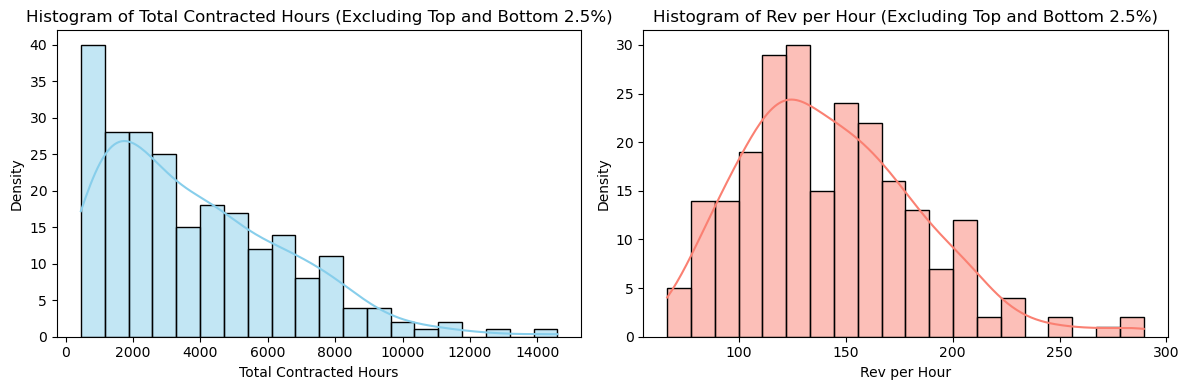

In [54]:
# Exclude top 2.5% and bottom 2.5% of clients based on 'Total Contracted Hours'
filtered_clients = active_client_df[(active_client_df['Total Contracted Hours'] > bottom_quantile) & 
                                    (active_client_df['Total Contracted Hours'] < top_quantile)]

# Create a figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram with KDE for 'Total Contracted Hours'
sns.histplot(data=filtered_clients, x='Total Contracted Hours', bins=20, color='skyblue', kde=True, ax=axs[0])
axs[0].set_title('Histogram of Total Contracted Hours (Excluding Top and Bottom 2.5%)')
axs[0].set_xlabel('Total Contracted Hours')
axs[0].set_ylabel('Density')

# Calculate 'Rev per Hour' for the filtered clients
filtered_rev_per_hour = filtered_clients['Total TCV'] / filtered_clients['Total Contracted Hours']

# Plot histogram with KDE for 'Rev per Hour'
sns.histplot(data=filtered_rev_per_hour, bins=20, color='salmon', kde=True, ax=axs[1])
axs[1].set_title('Histogram of Rev per Hour (Excluding Top and Bottom 2.5%)')
axs[1].set_xlabel('Rev per Hour')
axs[1].set_ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()

#### 4. Pareto Analysis with ACV - Active contracts

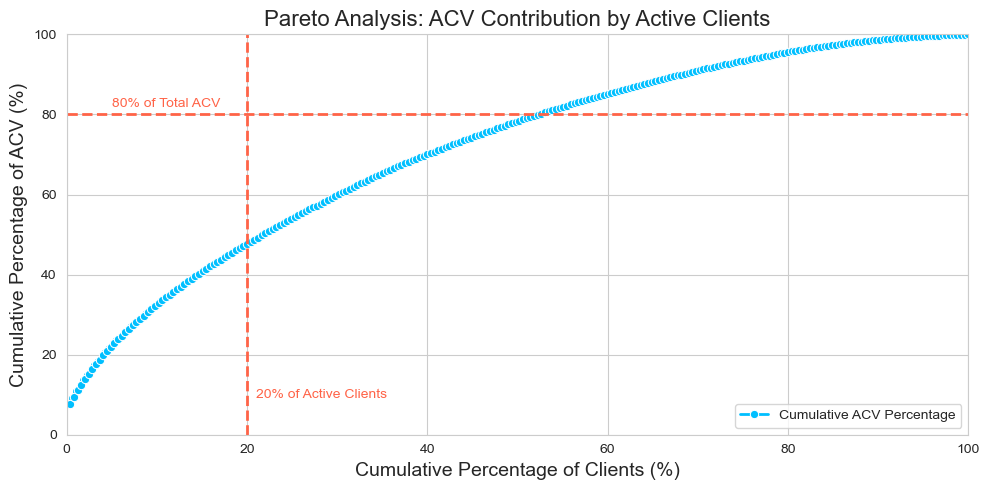

In [55]:
# Calculate ACV per Client
ACV_per_client = active_contract_df.groupby('Client ID')['ACV'].sum().sort_values(ascending=False)

# Convert ACV_per_client to DataFrame
ACV_per_client_df = ACV_per_client.reset_index(name='ACV')

# Correct calculation for Cumulative ACV
# This ensures that the cumulative sum is calculated correctly on the DataFrame's 'ACV' column
ACV_per_client_df['Cumulative ACV'] = ACV_per_client_df['ACV'].cumsum()

# Calculate Cumulative ACV Percentage
ACV_per_client_df['Cumulative ACV Percentage'] = 100 * ACV_per_client_df['Cumulative ACV'] / ACV_per_client_df['ACV'].sum()

# Calculate Cumulative Client Percentage
ACV_per_client_df['Cumulative Client Percentage'] = 100 * np.arange(1, len(ACV_per_client_df) + 1) / len(ACV_per_client_df)

# Plotting the Pareto graph
plt.figure(figsize=(10, 5))

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Line plot for Cumulative ACV Percentage
sns.lineplot(data=ACV_per_client_df, x='Cumulative Client Percentage', y='Cumulative ACV Percentage', 
             drawstyle='steps-pre', marker='o', color='deepskyblue', lw=2, label='Cumulative ACV Percentage')

# Adding a horizontal line at 80% to highlight the Pareto Principle threshold
plt.axhline(80, color='tomato', linestyle='--', lw=2, label='80% ACV')

# Adding a vertical line at 20% to see if the top 20% clients contribute to 80% of ACV
plt.axvline(20, color='tomato', linestyle='--', lw=2, label='20% Clients')

# Adding text annotations for clarity
plt.text(21, 10, '20% of Active Clients', color='tomato', va='center', ha='left')
plt.text(5, 81, '80% of Total ACV', color='tomato', va='bottom', ha='left')

# Setting the axes and plot titles, and labels
plt.xlabel('Cumulative Percentage of Clients (%)', fontsize=14)
plt.ylabel('Cumulative Percentage of ACV (%)', fontsize=14)
plt.title('Pareto Analysis: ACV Contribution by Active Clients', fontsize=16)

# Adjust the plot limits and layout
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

# Show plot
plt.show()

**Observation:** 
- The top 20% Active clients (105 clients) account for roughly 50% of ACV that this company has sold
- The top 55% Active clients (290 clients) account for rouhgly 80% of ACV that this company has sols

#### 5. ARR waterfall by Clients Cohort (Join Fiscal Quarter) / Cohort Analysis

In [56]:
# Grouping the data by client cohort start year, quarter, and month
cohort_analysis = client_sum_df.groupby(['Client Cohort Start FY', 'Client Cohort Start FQ'])

# Aggregating metrics
ARR_waterfall_by_client = cohort_analysis.agg({
    'Client ID': 'nunique',
    'Total TCV': 'mean',
    'Total Contracted Hours': 'mean',
    'ARR_as_of_2016-12-31': 'sum',
    'ARR_as_of_2017-03-31': 'sum',
    'ARR_as_of_2017-06-30': 'sum',
    'ARR_as_of_2017-09-30': 'sum',
    'ARR_as_of_2017-12-31': 'sum',
    'ARR_as_of_2018-03-31': 'sum',
    'ARR_as_of_2018-06-30': 'sum',
    'ARR_as_of_2018-09-30': 'sum',
    'ARR_as_of_2018-12-31': 'sum',
    'ARR_as_of_2019-03-31': 'sum',
    'ARR_as_of_2019-06-30': 'sum',
    'ARR_as_of_2019-09-30': 'sum',
    'ARR_as_of_2019-12-31': 'sum',
    'ARR_as_of_2020-03-31': 'sum',
    'ARR_as_of_2020-06-30': 'sum',
    'ARR_as_of_2020-09-30': 'sum',
    'ARR_as_of_2020-12-31': 'sum',
    'ARR_as_of_2021-03-31': 'sum',
    'ARR_as_of_2021-06-30': 'sum',
    'ARR_as_of_2021-09-30': 'sum',
    'ARR_as_of_2021-12-31': 'sum'
})

# Renaming columns
ARR_waterfall_by_client = ARR_waterfall_by_client.rename(columns={
    'Client ID': 'Count of Clients',
    'Count of Contract ID': 'Count of Contracts',
    'Total TCV': 'Average TCV per Client',
    'Total Contracted Hours': 'Average Contracted Hours per Client'
})

# Displaying the cohort analysis summary
display(ARR_waterfall_by_client)

Count of Clients  \
Client Cohort Start FY Client Cohort Start FQ                     
2017                   Q2                                     1   
                       Q3                                     2   
2018                   Q1                                     1   
                       Q2                                     1   
                       Q3                                     4   
                       Q4                                     6   
2019                   Q1                                     7   
                       Q2                                     4   
                       Q3                                     9   
                       Q4                                    17   
2020                   Q1                                    19   
                       Q2                                    10   
                       Q3                                    14   
                       Q4                                    27   
2021                   Q1                                    47   
                       Q2                                    21   
                       Q3                                    24   
                       Q4                                    28   
2022                   Q1                                    18   
                       Q2                                     4   

                                               Average TCV per Client  \
Client Cohort Start FY Client Cohort Start FQ                           
2017                   Q2                                     240,000   
                       Q3                                     296,945   
2018                   Q1                                  14,637,045   
                       Q2                                     801,240   
                       Q3                                   1,657,992   
                       Q4                                   1,127,125   
2019                   Q1                                   2,233,580   
                       Q2                                     594,084   
                       Q3                                     615,517   
                       Q4                                     484,472   
2020                   Q1                                     533,428   
                       Q2                                     446,025   
                       Q3                                     623,081   
                       Q4                                     769,558   
2021                   Q1                                     463,236   
                       Q2                                     346,272   
                       Q3                                     485,308   
                       Q4                                     506,161   
2022                   Q1                                     152,289   
                       Q2                                     358,637   

                                               Average Contracted Hours per Client  \
Client Cohort Start FY Client Cohort Start FQ                                        
2017                   Q2                                                    1,500   
                       Q3                                                    1,820   
2018                   Q1                                                  108,180   
                       Q2                                                    7,180   
                       Q3                                                   13,582   
                       Q4                                                    7,842   
2019                   Q1                                                   15,433   
                       Q2                                                    4,490   
                       Q3                                                    5,338   
                   

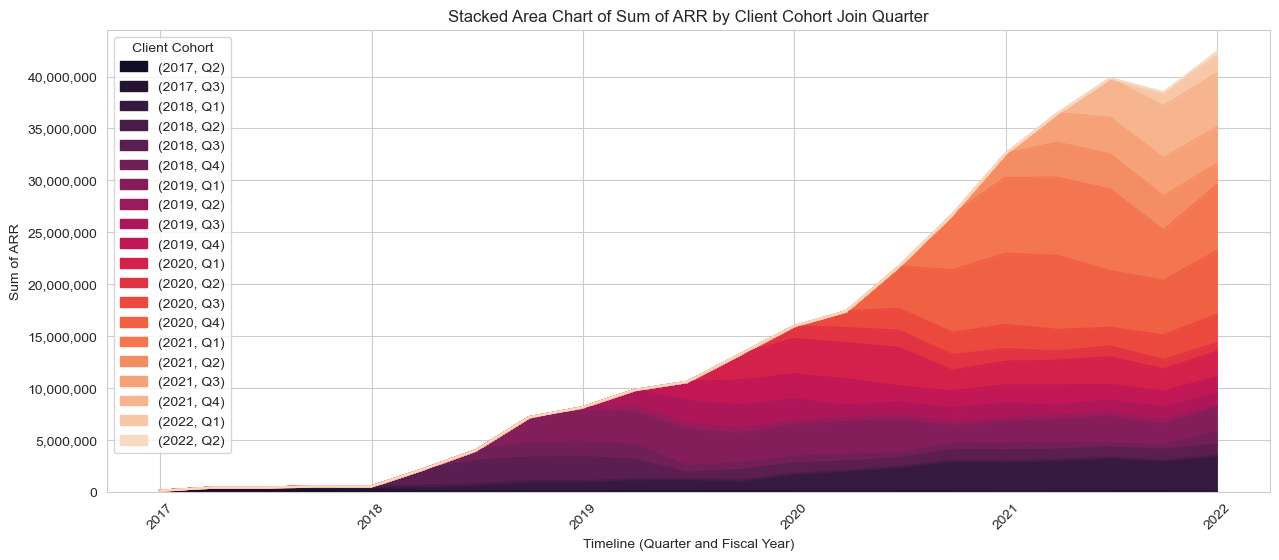

In [58]:
ARR_columns = ['ARR_as_of_2016-12-31',
       'ARR_as_of_2017-03-31', 'ARR_as_of_2017-06-30', 'ARR_as_of_2017-09-30',
       'ARR_as_of_2017-12-31', 'ARR_as_of_2018-03-31', 'ARR_as_of_2018-06-30',
       'ARR_as_of_2018-09-30', 'ARR_as_of_2018-12-31', 'ARR_as_of_2019-03-31',
       'ARR_as_of_2019-06-30', 'ARR_as_of_2019-09-30', 'ARR_as_of_2019-12-31',
       'ARR_as_of_2020-03-31', 'ARR_as_of_2020-06-30', 'ARR_as_of_2020-09-30',
       'ARR_as_of_2020-12-31', 'ARR_as_of_2021-03-31', 'ARR_as_of_2021-06-30',
       'ARR_as_of_2021-09-30', 'ARR_as_of_2021-12-31']

# Select specific columns from ARR_waterfall_by_client and create a copy
ARR_waterfall_by_client_short = ARR_waterfall_by_client[ARR_columns].copy()

# Create a dictionary mapping ARR_df_col_name to specific_date
column_name_mapping = dict(zip(specific_date_tracker['ARR_df_col_name'], specific_date_tracker['specific_date']))

# Rename the columns of ARR_waterfall_by_client
ARR_waterfall_by_client_short.rename(columns=column_name_mapping, inplace=True)

# Transpose the DataFrame to have quarters as columns
ARR_waterfall_by_client_transposed = ARR_waterfall_by_client_short.T

# Specify the color palette
palette = sns.color_palette("rocket", len(ARR_waterfall_by_client_transposed.columns))

# Plot the stacked area chart with the specified color palette
ax = ARR_waterfall_by_client_transposed.plot.area(figsize=(15, 6), color=palette)
plt.xlabel('Timeline (Quarter and Fiscal Year)')
plt.ylabel('Sum of ARR')
plt.title('Stacked Area Chart of Sum of ARR by Client Cohort Join Quarter')
plt.xticks(rotation=45)
plt.legend(title='Client Cohort')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(format_func)

plt.show()